MemoryInfo(free=15420489728, total=16911433728)
6523164.234790019
29.250712871551514


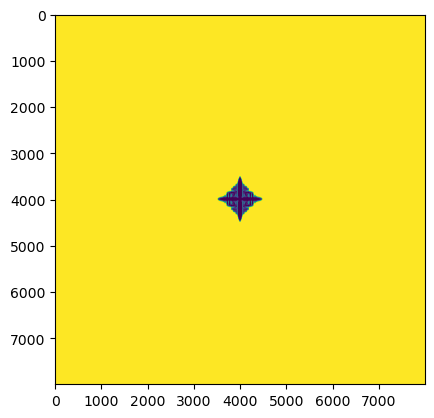

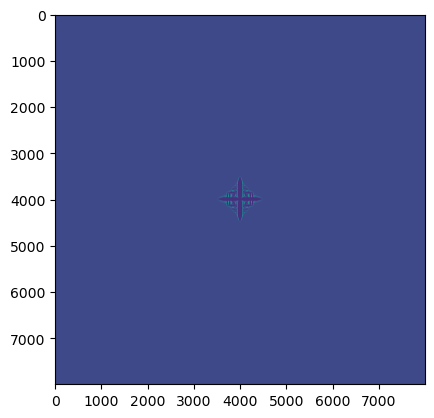

26073076.433106028


In [4]:
from numba import cuda
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32

cuda.select_device(3)
print(cuda.current_context().get_memory_info())

@cuda.jit
def warren1995_kernel(phi, c, D, temp, phi_out, c_out, rng_states, T):
    
    startx, starty = cuda.grid(2)    
    stridex, stridey = cuda.gridsize(2) 
    thread_id = cuda.grid(1)
    
    T = T
    T_mA = 1728.
    T_mB = 1358.
    L_A = 2350.
    L_B = 1728.
    s_A = 0.000037
    s_B = 0.000029
    D_L = 0.00001
    D_S = 0.000000001
    B_A = 0.33
    B_B = 0.39
    v_m = 7.42
    R = 8.314
    y_e = 0.04
    a = 0.3
    dx = 4.6e-06
    d = dx/0.94
    dt = dx*dx/(5.*D_L)
    
    M_A = T_mA*T_mA*B_A/(6.*math.sqrt(2.)*L_A*d)
    M_B = T_mB*T_mB*B_B/(6.*math.sqrt(2.)*L_B*d)
    W_A = 3.*s_A/(math.sqrt(2.)*T_mA*d)
    W_B = 3.*s_B/(math.sqrt(2.)*T_mB*d)
    e2 = 6.*math.sqrt(2.)*s_A*d/T_mA

    # assuming x and y inputs are same length
    for i in range(starty, phi.shape[0], stridey):
        for j in range(startx, phi.shape[1], stridex):
            g = (phi[i][j]**2)*(1-phi[i][j])**2
            gprime = 4*phi[i][j]**3 - 6*phi[i][j]**2 + 2*phi[i][j]
            H_A = W_A*gprime + 30.*g*L_A*(1./T-1./T_mA)
            H_B = W_B*gprime + 30.*g*L_B*(1./T-1./T_mB)
            
            idx = 1./dx
            
            dphidx = 0.5*(phi[i][j+1]-phi[i][j-1])*idx
            dphidy = 0.5*(phi[i+1][j]-phi[i-1][j])*idx
            d2phidx2 = (phi[i][j+1]+phi[i][j-1]-2*phi[i][j])*idx*idx
            d2phidy2 = (phi[i+1][j]+phi[i-1][j]-2*phi[i][j])*idx*idx
            lphi = d2phidx2 + d2phidy2
            d2phidxy = 0.25*(phi[i+1][j+1]-phi[i+1][j-1]-phi[i-1][j+1]+phi[i-1][j-1])*idx*idx
            theta = math.atan2(dphidy, dphidx)
            eta = 1+y_e*math.cos(4*theta)
            etaprime = -4*y_e*math.sin(4*theta)
            etadoubleprime = -16*(eta-1)
            
            M_phi = (1-c[i][j])*M_A + c[i][j]*M_B
            
            dphidt = e2*eta*eta*lphi - (1.-c[i][j])*H_A - c[i][j]*H_B 
            dphidt += e2*eta*etaprime*(math.sin(2.*theta)*(d2phidy2-d2phidx2) + 2.*math.cos(2.*theta)*d2phidxy)
            dphidt -= 0.5*e2*(etaprime*etaprime + eta*etadoubleprime)*(2.*math.sin(2.*theta)*d2phidxy - lphi - math.cos(2.*theta)*(d2phidy2-d2phidx2))
            random = xoroshiro128p_uniform_float32(rng_states, thread_id)
            dphidt += a*16*g*((1-c[i][j])*H_A + c[i][j]*H_B)*(2.*random-1.)
            dphidt *= M_phi
            
            #dcdt = D[i][j]*(c[i][j+1]+c[i][j-1]+c[i+1][j]+c[i-1][j]-4*c[i][j])
            #dcdt += 0.25*(D[i][j+1]-D[i][j-1])*(c[i][j+1]-c[i][j-1])
            #dcdt += 0.25*(D[i+1][j]-D[i-1][j])*(c[i+1][j]-c[i-1][j])
            #dcdt *= (idx*idx)
            #dcdt += temp[i][j]*lphi
            #dcdt += 0.5*(temp[i][j+1]-temp[i][j-1])*dphidx*idx
            #dcdt += 0.5*(temp[i+1][j]-temp[i-1][j])*dphidy*idx
            
            dcdt = 0.5*idx*idx*((D[i+1][j] + D[i][j])*(c[i+1][j] - c[i][j]) - (D[i][j] + D[i-1][j])*(c[i][j] - c[i-1][j]))
            dcdt += 0.5*idx*idx*((D[i][j+1] + D[i][j])*(c[i][j+1] - c[i][j]) - (D[i][j] + D[i][j-1])*(c[i][j] - c[i][j-1]))
            dcdt += 0.5*idx*idx*((temp[i+1][j] + temp[i][j])*(phi[i+1][j] - phi[i][j]) - (temp[i][j] + temp[i-1][j])*(phi[i][j] - phi[i-1][j]))
            dcdt += 0.5*idx*idx*((temp[i][j+1] + temp[i][j])*(phi[i][j+1] - phi[i][j]) - (temp[i][j] + temp[i][j-1])*(phi[i][j] - phi[i][j-1]))
            
            phi_out[i][j] = phi[i][j] + dphidt*dt
            c_out[i][j] = c[i][j] + dcdt*dt
            
@cuda.jit
def warren1995_helper_kernel(phi, c, D, temp, T):
    startx, starty = cuda.grid(2)     
    stridex, stridey = cuda.gridsize(2) 
    
    T = T
    T_mA = 1728.
    T_mB = 1358.
    L_A = 2350.
    L_B = 1728.
    s_A = 0.000037
    s_B = 0.000029
    D_L = 0.00001
    D_S = 0.000000001
    v_m = 7.42
    R = 8.314
    dx = 4.6e-06
    d = dx/0.25
    
    W_A = 3.*s_A/(math.sqrt(2.)*T_mA*d)
    W_B = 3.*s_B/(math.sqrt(2.)*T_mB*d)
    
    for i in range(startx, phi.shape[0], stridex):
        for j in range(starty, phi.shape[1], stridey):
            g = (phi[i][j]**2)*(1.-phi[i][j])**2
            gprime = 4.*phi[i][j]**3 - 6.*phi[i][j]**2 + 2.*phi[i][j]
            p = (phi[i][j]**3)*(10.-15.*phi[i][j]+6.*phi[i][j]**2)
            H_A = W_A*gprime + 30.*g*L_A*(1./T-1./T_mA)
            H_B = W_B*gprime + 30.*g*L_B*(1./T-1./T_mB)
            D[i][j] = D_S+p*(D_L-D_S)
            temp[i][j] = D[i][j]*v_m*c[i][j]*(1-c[i][j])*(H_B-H_A)/R
            
@cuda.jit
def warren1995_combined_kernel(phi_device, c_device, phi_out_device, c_out_device, rng_states, T, wall):
    startx, starty = cuda.grid(2)    
    stridex, stridey = cuda.gridsize(2) 
    thread_id = cuda.grid(1)
    
    T = T
    T_mA = 1728.
    T_mB = 1358.
    L_A = 2350.
    L_B = 1728.
    s_A = 0.000037
    s_B = 0.000029
    D_L = 0.00001
    D_S = 0.000000001
    B_A = 0.33
    B_B = 0.39
    v_m = 7.42
    R = 8.314
    y_e = 0.04
    a = 0.3
    dx = 4.6e-06
    d = dx/0.94
    dt = dx*dx/(5.*D_L)
    
    #gr = cuda.cg.this_grid()
    
    M_A = T_mA*T_mA*B_A/(6.*math.sqrt(2.)*L_A*d)
    M_B = T_mB*T_mB*B_B/(6.*math.sqrt(2.)*L_B*d)
    W_A = 3.*s_A/(math.sqrt(2.)*T_mA*d)
    W_B = 3.*s_B/(math.sqrt(2.)*T_mB*d)
    e2 = 6.*math.sqrt(2.)*s_A*d/T_mA
    
    size = stridex*stridey

    # assuming x and y inputs are same length
    for k in range(1):
        if k%2 == 0:
            phi = phi_device
            c = c_device
            phi_out = phi_out_device
            c_out = c_out_device
        else:
            phi = phi_out_device
            c = c_out_device
            phi_out = phi_device
            c_out = c_device
        for i in range(starty+1, phi.shape[0]-1, stridey):
            for j in range(startx+1, phi.shape[1]-1, stridex):
                g = (phi[i][j]**2)*(1-phi[i][j])**2
                gprime = 4*phi[i][j]**3 - 6*phi[i][j]**2 + 2*phi[i][j]
                H_A = W_A*gprime + 30.*g*L_A*(1./T-1./T_mA)
                H_B = W_B*gprime + 30.*g*L_B*(1./T-1./T_mB)

                idx = 1./dx

                dphidx = 0.5*(phi[i][j+1]-phi[i][j-1])*idx
                dphidy = 0.5*(phi[i+1][j]-phi[i-1][j])*idx
                d2phidx2 = (phi[i][j+1]+phi[i][j-1]-2*phi[i][j])*idx*idx
                d2phidy2 = (phi[i+1][j]+phi[i-1][j]-2*phi[i][j])*idx*idx
                lphi = d2phidx2 + d2phidy2
                d2phidxy = 0.25*(phi[i+1][j+1]-phi[i+1][j-1]-phi[i-1][j+1]+phi[i-1][j-1])*idx*idx
                theta = math.atan2(dphidy, dphidx)
                eta = 1+y_e*math.cos(4*theta)
                etaprime = -4*y_e*math.sin(4*theta)
                etadoubleprime = -16*(eta-1)

                M_phi = (1-c[i][j])*M_A + c[i][j]*M_B

                dphidt = e2*eta*eta*lphi - (1.-c[i][j])*H_A - c[i][j]*H_B 
                dphidt += e2*eta*etaprime*(math.sin(2.*theta)*(d2phidy2-d2phidx2) + 2.*math.cos(2.*theta)*d2phidxy)
                dphidt -= 0.5*e2*(etaprime*etaprime + eta*etadoubleprime)*(2.*math.sin(2.*theta)*d2phidxy - lphi - math.cos(2.*theta)*(d2phidy2-d2phidx2))
                random = xoroshiro128p_uniform_float32(rng_states, thread_id)
                dphidt += a*16*g*((1-c[i][j])*H_A + c[i][j]*H_B)*(2.*random-1.)
                dphidt *= M_phi

                Dl = D_S+(phi[i-1][j]**3)*(10.-15.*phi[i-1][j]+6.*phi[i-1][j]**2)*(D_L-D_S)
                Dr = D_S+(phi[i+1][j]**3)*(10.-15.*phi[i+1][j]+6.*phi[i+1][j]**2)*(D_L-D_S)
                Du = D_S+(phi[i][j+1]**3)*(10.-15.*phi[i][j+1]+6.*phi[i][j+1]**2)*(D_L-D_S)
                Dd = D_S+(phi[i][j-1]**3)*(10.-15.*phi[i][j-1]+6.*phi[i][j-1]**2)*(D_L-D_S)
                Dc = D_S+(phi[i][j]**3)*(10.-15.*phi[i][j]+6.*phi[i][j]**2)*(D_L-D_S)

                phi_temp = phi[i-1][j]
                c_temp = c[i-1][j]
                g = (phi_temp**2)*(1.-phi_temp)**2
                gprime = 4.*phi_temp**3 - 6.*phi_temp**2 + 2.*phi_temp
                H_A = W_A*gprime + 30.*g*L_A*(1./T-1./T_mA)
                H_B = W_B*gprime + 30.*g*L_B*(1./T-1./T_mB)
                templ = Dl*v_m*c_temp*(1-c_temp)*(H_B-H_A)/R
                phi_temp = phi[i+1][j]
                c_temp = c[i+1][j]
                g = (phi_temp**2)*(1.-phi_temp)**2
                gprime = 4.*phi_temp**3 - 6.*phi_temp**2 + 2.*phi_temp
                H_A = W_A*gprime + 30.*g*L_A*(1./T-1./T_mA)
                H_B = W_B*gprime + 30.*g*L_B*(1./T-1./T_mB)
                tempr = Dr*v_m*c_temp*(1-c_temp)*(H_B-H_A)/R
                phi_temp = phi[i][j+1]
                c_temp = c[i][j+1]
                g = (phi_temp**2)*(1.-phi_temp)**2
                gprime = 4.*phi_temp**3 - 6.*phi_temp**2 + 2.*phi_temp
                H_A = W_A*gprime + 30.*g*L_A*(1./T-1./T_mA)
                H_B = W_B*gprime + 30.*g*L_B*(1./T-1./T_mB)
                tempu = Du*v_m*c_temp*(1-c_temp)*(H_B-H_A)/R
                phi_temp = phi[i][j-1]
                c_temp = c[i][j-1]
                g = (phi_temp**2)*(1.-phi_temp)**2
                gprime = 4.*phi_temp**3 - 6.*phi_temp**2 + 2.*phi_temp
                H_A = W_A*gprime + 30.*g*L_A*(1./T-1./T_mA)
                H_B = W_B*gprime + 30.*g*L_B*(1./T-1./T_mB)
                tempd = Dd*v_m*c_temp*(1-c_temp)*(H_B-H_A)/R
                phi_temp = phi[i][j]
                c_temp = c[i][j]
                g = (phi_temp**2)*(1.-phi_temp)**2
                gprime = 4.*phi_temp**3 - 6.*phi_temp**2 + 2.*phi_temp
                H_A = W_A*gprime + 30.*g*L_A*(1./T-1./T_mA)
                H_B = W_B*gprime + 30.*g*L_B*(1./T-1./T_mB)
                tempc = Dc*v_m*c_temp*(1-c_temp)*(H_B-H_A)/R

                dcdt = 0.5*idx*idx*((Dr + Dc)*(c[i+1][j] - c[i][j]) - (Dc + Dl)*(c[i][j] - c[i-1][j]))
                dcdt += 0.5*idx*idx*((Du + Dc)*(c[i][j+1] - c[i][j]) - (Dc + Dd)*(c[i][j] - c[i][j-1]))
                dcdt += 0.5*idx*idx*((tempr + tempc)*(phi[i+1][j] - phi[i][j]) - (tempc + templ)*(phi[i][j] - phi[i-1][j]))
                dcdt += 0.5*idx*idx*((tempu + tempc)*(phi[i][j+1] - phi[i][j]) - (tempc + tempd)*(phi[i][j] - phi[i][j-1]))

                phi_out[i][j] = phi[i][j] + dphidt*dt
                c_out[i][j] = c[i][j] + dcdt*dt
        #gr.sync()
        """
        for i in range(starty+startx*stridey, phi.shape[1], stridey*stridex):
            phi_out[0][i] = phi_out[1][i]
            phi_out[phi.shape[0]-1][i] = phi_out[phi.shape[0]-2][i]
            c_out[0][i] = c_out[1][i]
            c_out[phi.shape[0]-1][i] = c_out[phi.shape[0]-2][i]
        #gr.sync()
        for i in range(starty+startx*stridey, phi.shape[0], stridey*stridex):
            phi_out[i][0] = phi_out[i][1]
            phi_out[i][phi.shape[1]-1] = phi_out[i][phi.shape[1]-2]
            c_out[i][0] = c_out[i][1]
            c_out[i][phi.shape[1]-1] = c_out[i][phi.shape[1]-2]
        """
        #gr.sync()
    
@cuda.jit
def neumann_boundary_conditions_kernel(out):
    startx, starty = cuda.grid(2)     
    stridex, stridey = cuda.gridsize(2) 

    # assuming x and y inputs are same length
    for i in range(starty+startx*stridey, out.shape[1], stridey*stridex):
            out[0][i] = out[1][i]
            out[out.shape[0]-1][i] = out[out.shape[0]-2][i]
    for i in range(starty+startx*stridey, out.shape[0], stridey*stridex):
            out[i][0] = out[i][1]
            out[i][out.shape[1]-1] = out[i][out.shape[1]-2]

@cuda.jit
def periodic_boundary_conditions_kernel(out):
    startx, starty = cuda.grid(2)
    stridex, stridey = cuda.gridsize(2)

    # assuming x and y inputs are same length
    for i in range(starty+startx*stridey, out.shape[1], stridey*stridex):
            out[0][i] = out[out.shape[0]-2][i]
            out[out.shape[0]-1][i] = out[1][i]
    for i in range(starty+startx*stridey, out.shape[0], stridey*stridex):
            out[i][0] = out[i][out.shape[1]-2]
            out[i][out.shape[1]-1] = out[i][1]
            
for j in np.arange(1574, 1574.05, 0.1):

    n = 4000
    c = np.zeros((n,n)).astype(np.float64)
    c[:] = 0.40831
    c = np.transpose(c)
    print(np.sum(c[1:-2,1:-2]))
    phi = np.zeros((n,n)).astype(np.float64)
    phi += 1
    phi = np.transpose(phi)

    diamond_size = 15
    for i in range(diamond_size):
        phi[0:(diamond_size-i),i] = 0
        #phi[n//2-(diamond_size-i):n//2+(diamond_size-i),n//2-i:n//2+i] = 0
    
    phi_device = cuda.to_device(phi)
    c_device = cuda.to_device(c)
    phi_out_device = cuda.device_array_like(c)
    c_out_device = cuda.device_array_like(c)
    D_device = cuda.device_array_like(c)
    temp_device = cuda.device_array_like(c)
    
    wall = np.zeros([4], dtype=int)
    wall_device = cuda.to_device(wall)

    threads_per_block = (16,16)
    blocks_per_grid = (16,16)
    t0 = time.time()
    neumann_boundary_conditions_kernel[blocks_per_grid, threads_per_block](phi_device)
    neumann_boundary_conditions_kernel[blocks_per_grid, threads_per_block](c_device)
    rng_states = create_xoroshiro128p_states(256*256, seed=3)
    for i in range(4000):
        """
        warren1995_helper_kernel[blocks_per_grid, threads_per_block](phi_device, c_device, D_device, temp_device, j)
        cuda.synchronize()
        warren1995_kernel[blocks_per_grid, threads_per_block](phi_device, c_device, D_device, temp_device, phi_out_device, c_out_device, rng_states, j)
        cuda.synchronize()
        """
        warren1995_combined_kernel[blocks_per_grid, threads_per_block](phi_device, c_device, phi_out_device, c_out_device, rng_states, j, wall_device)
        cuda.synchronize()
        
        neumann_boundary_conditions_kernel[blocks_per_grid, threads_per_block](phi_out_device)
        neumann_boundary_conditions_kernel[blocks_per_grid, threads_per_block](c_out_device)
        cuda.synchronize()
        
        temp = c_device
        c_device = c_out_device
        c_out_device = temp
        temp = phi_device
        phi_device = phi_out_device
        phi_out_device = temp
        
        cuda.synchronize()
    t1 = time.time()
    print(t1-t0)
    c_host = c_device.copy_to_host()
    c_host = c_host[1:-2, 1:-2]
    c_host = np.concatenate((c_host[::-1], c_host), axis=0)
    c_host = np.concatenate((c_host[:,::-1], c_host), axis=1)
    phi_host = phi_device.copy_to_host()
    phi_host = phi_host[1:-2, 1:-2]
    phi_host = np.concatenate((phi_host[::-1], phi_host), axis=0)
    phi_host = np.concatenate((phi_host[:,::-1], phi_host), axis=1)
    
    plt.imshow(phi_host, interpolation="bicubic")
    #plt.text(1300, 1900, "T = "+str.format('{0:.1f}', j), color='black', fontsize=12)
    #plt.savefig("phi_"+str.format('{0:.1f}', j)+".png")
    plt.show()
    plt.imshow(c_host, interpolation="bicubic")
    #plt.text(1300, 1900, "T = "+str.format('{0:.1f}', j), color='white', fontsize=12)
    #plt.savefig("c_"+str.format('{0:.1f}', j)+".png")
    plt.show()
    print(np.sum(c_host[1:-2,1:-2]))

In [46]:
import numba
numba.max_cooperative_grid_blocks()

AttributeError: module 'numba' has no attribute 'max_cooperative_grid_blocks'

In [2]:
import pyphasefield as ppf

sim = ppf.Simulation("test")
sim.init_sim_Warren1995(dim=[1000,1000])
%timeit -n5 sim.simulate(10)

17.4 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


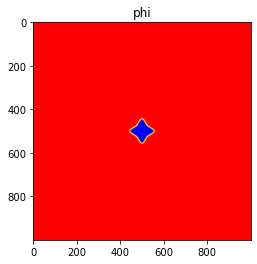

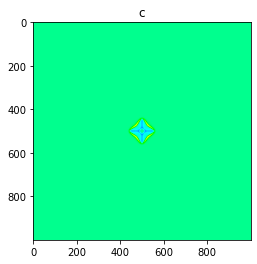

In [3]:
sim.plot_simulation()